### Near inertial waves signal extraction and demodulation

In [1]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
import pandas as pd
import scipy.signal as signal

import niskine
import mplniw.plot as pl
import gvpy as gv
import mplniw.sigp as sp
import mplniw.utils as ut

In [2]:
conf = niskine.io.load_config()
lon, lat, bottom_depth = niskine.io.mooring_location(mooring=1)
root_dir = '/Users/zcasparcohen/codes/NIW/data/'
figdir = '/Users/zcasparcohen/Documents/NISKINE/Figures/'

In [3]:
#Definition filter
Tw = 30  # Kernel length
#omega = 2.0 
omega = ut.coriolis(lat)*3600*24/(2*np.pi)  # Central frequency
#bandwidth = None 
bandwidth = 0.1
dt = 1/(24*6)  # Time step in days unit
h = ut.generate_filter(omega,dt=dt,T=Tw,bandwidth=bandwidth,lat=lat,pass_zero=False)  # Best filter
h_hat, w = ut.filter_response(h, dt=dt)  #Filter response

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


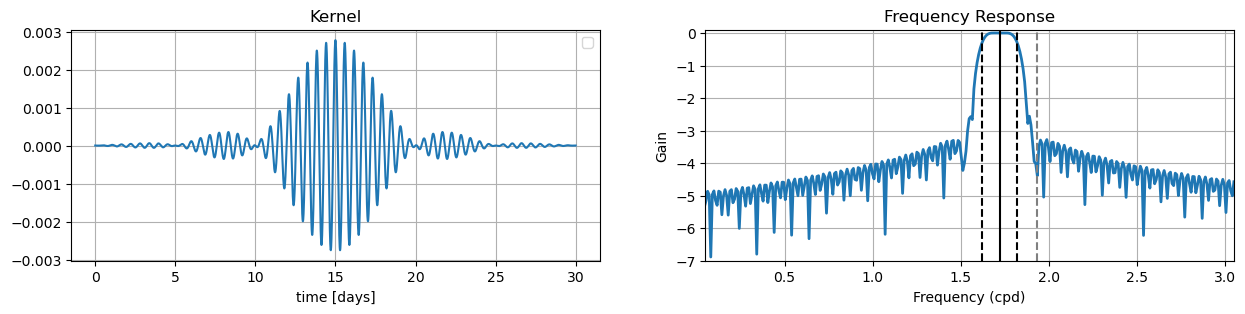

In [4]:
t = np.arange(0,Tw,dt)
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
ax.plot(t, h)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]

ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(omega, color='k')
ax.axvline(omega-bandwidth, color='k',ls='--')
ax.axvline(omega+bandwidth, color='k',ls='--')
ax.axvline(1.9323, color='grey', ls='--')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

In [5]:
mooring=1
gridded=xr.open_dataset(root_dir+'M%s_linear_merge_slinearfill.nc'%mooring)[['u','v']]
ds = sp.wrap_filter(gridded,h,**{'hilbert':False})

In [6]:
mld_m1 = xr.open_dataarray(conf.data.ml.mld).sel(time=slice(ds.time[0],ds.time[-1]))
ds['mld'] = mld_m1
wkb = niskine.clim.get_wkb_factors(gridded)
ds['bpu_wkb'] = ds['u_filtered']*wkb
ds['bpv_wkb'] = ds['v_filtered']*wkb
#ds.bp_eke.attrs.update({'long_name':'Kinetic energy', 'units':r'$m^2.s^{-2}$'})
ds.bpu_wkb.attrs.update({'long_name':'Zonal velocity', 'units':r'$m.s^{-1}$'})
ds.bpv_wkb.attrs.update({'long_name':'Meridional velocity', 'units':r'$m.s^{-1}$'})
#ds['bp_eke'] = ds.bp_eke.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
ds['bpu_wkb'] = ds.bpu_wkb.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
ds['bpv_wkb'] = ds.bpv_wkb.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
ds['u_filtered'] = ds.u_filtered.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
ds['v_filtered'] = ds.v_filtered.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)

In [7]:
def wrap_hilbert(ds,fs=1/(24*6)):
    output_dtype = complex
    gufunc_kwargs = dict(output_sizes={'time': len(ds.time)})
    ds_copy = ds.copy()
    for v in ['u_filtered','v_filtered','bpu_wkb','bpv_wkb']:
        ds_copy[v+'_analytical'] = xr.apply_ufunc(signal.hilbert, ds[v].fillna(0), output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )
        ds_copy[v+'_envelope'] = np.abs(ds_copy[v+'_analytical'])
        ds_copy[v+'_phase'] = xr.DataArray(data=np.angle(ds_copy['u_filtered'+'_analytical']), dims=['z','time'],
                                           coords={'z':(['z'],ds_copy.z.values),'time':(['time'],ds_copy.time.values)})
        ds_copy[v+'_freq'] = xr.DataArray(data=(np.diff(ds_copy[v+'_phase'])/(2.0*np.pi) * fs), dims=['z','time'],
                                           coords={'z':(['z'],ds_copy.z.values),'time':(['time'],ds_copy.time.values[:-1])})
    return ds_copy

In [8]:
ds_complex = wrap_hilbert(ds)
ds_complex

<xarray.Dataset>
Dimensions:                (time: 73057, z: 125)
Coordinates:
  * time                   (time) datetime64[ns] 2019-05-17T16:00:00 ... 2020...
  * z                      (z) int64 0 16 32 48 64 ... 1920 1936 1952 1968 1984
Data variables: (12/23)
    u                      (z, time) float64 ...
    v                      (z, time) float64 ...
    u_filtered             (z, time) float64 nan nan nan nan ... nan nan nan nan
    v_filtered             (z, time) float64 nan nan nan nan ... nan nan nan nan
    mld                    (time) float64 79.88 79.86 79.84 ... nan nan nan
    bpu_wkb                (z, time) float64 nan nan nan nan ... nan nan nan nan
    ...                     ...
    bpu_wkb_phase          (z, time) float64 0.0 0.0 0.0 0.0 ... -0.0 -0.0 -0.0
    bpu_wkb_freq           (z, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan
    bpv_wkb_analytical     (z, time) complex128 0j 0j 0j 0j ... -0j -0j -0j -0j
    bpv_wkb_envelope       (z, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    bpv_wkb_phase          (z, time) float64 0.0 0.0 0.0 0.0 ... -0.0 -0.0 -0.0
    bpv_wkb_freq           (z, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan
Attributes:
    orientation:      down
    magdec:           -10.915967
    max_e:            0.2
    max_e_deviation:  2
    min_correlation:  64
    mooring:          M1
    sn:               13481
    project:          NISKINe
    Bin1Dist:         24.59
    NCells:           44
    CellSize:         16.0
    proc time:        2022-05-09T19:08:16

In [9]:
ds_complex = ds_complex.where(ds_complex.u_filtered_analytical != 0+1j*0)
ds_complex = ds_complex.where(np.isnan(ds_complex.bpu_wkb)==False)
#ds_complex = ds_complex.where(ds_complex.v_filtered_analytical != 0+1j*0)
#ds_complex = ds_complex.where(ds_complex.bpu_wkb_analytical != 0+1j*0)
#ds_complex = ds_complex.where(ds_complex.bpv_wkb_analytical != 0+1j*0)

In [11]:
_u = ds_complex.bpu_wkb_analytical

In [81]:
time = np.arange(0,_u.time.values.size*dt,dt)
exp  = np.exp(-1j*omega*2*np.pi*time)

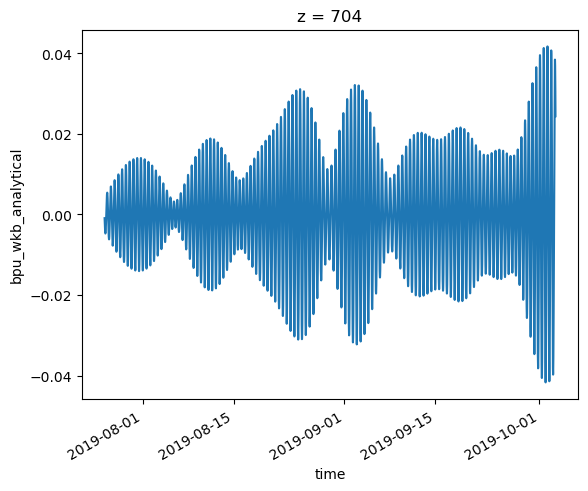

In [91]:
_u.real.sel(z=704).isel(time=slice(10000,20000)).plot()

In [82]:
_  = xr.Dataset({'u':_u,'exp':(['time'],exp)})
_.exp

<xarray.DataArray 'exp' (time: 73057)>
array([1.        +0.j        , 0.99718234-0.0750159j ,
       0.98874523-0.14960907j, ..., 0.98966843-0.14337501j,
       0.97612448-0.2172119j , 0.95707974-0.28982472j])
Coordinates:
  * time     (time) datetime64[ns] 2019-05-17T16:00:00 ... 2020-10-06

In [83]:
_['demod'] = _.u*_.exp

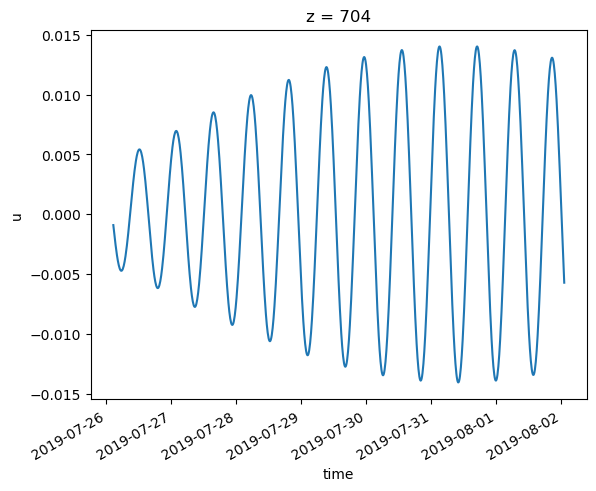

In [97]:
_.u.real.sel(z=704).isel(time=slice(10000,11000)).plot()

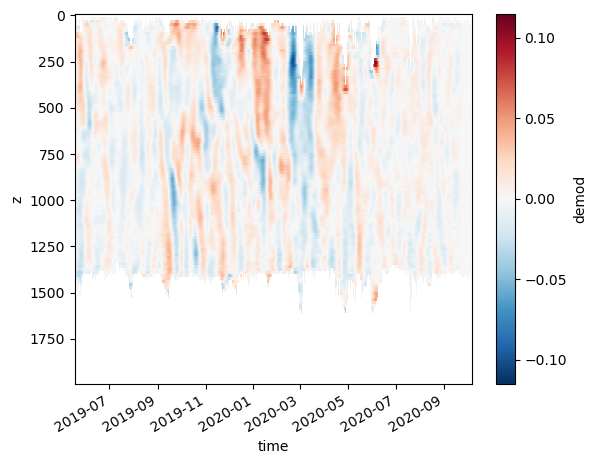

In [85]:
_.demod.real.plot(yincrease=False)

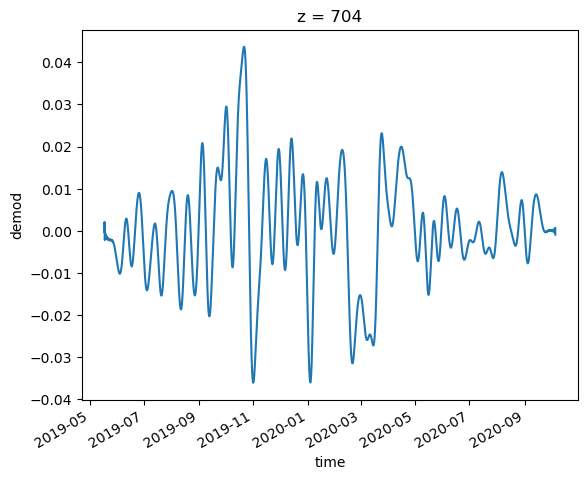

In [86]:
_.demod.sel(z=704).real.plot()

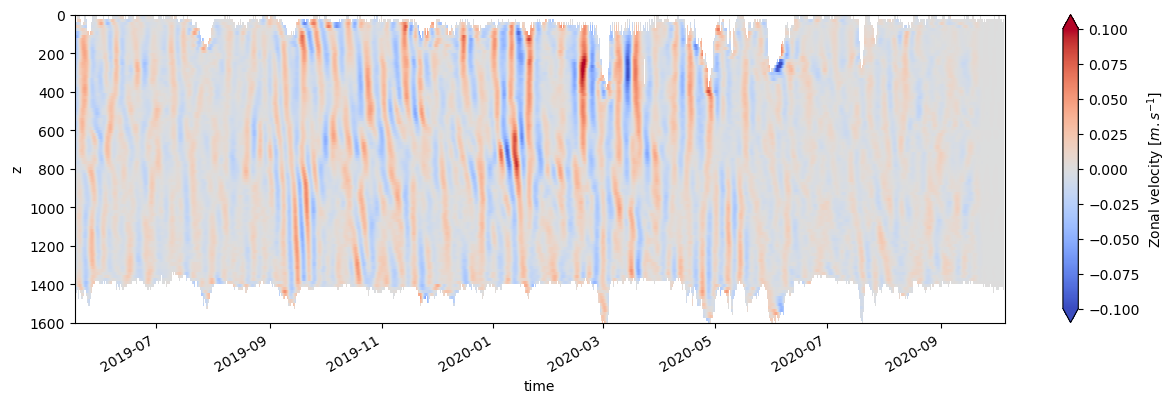

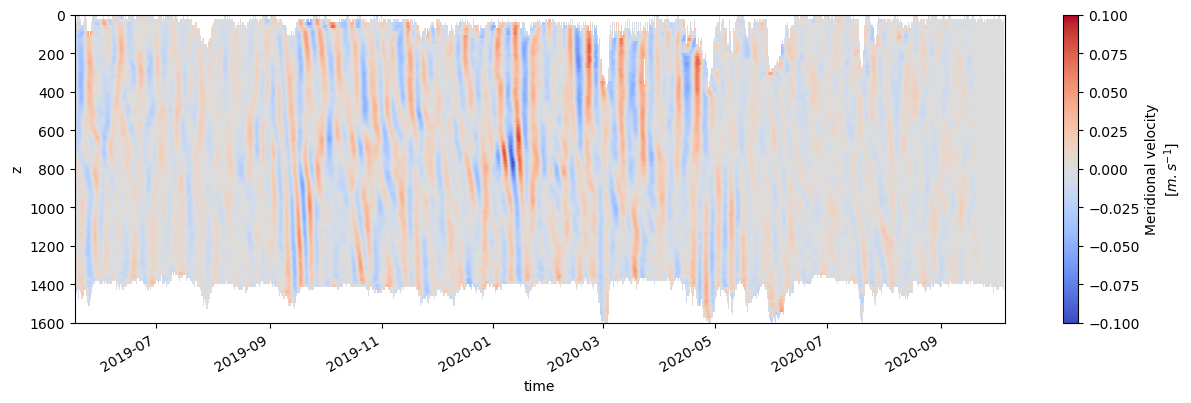

In [125]:
plt.figure(figsize=(15,4))
ds_complex.bpu_wkb.plot(yincrease=False,ylim=(1600,0),cmap='coolwarm',vmax=0.1)
plt.figure(figsize=(15,4))
ds_complex.bpv_wkb.plot(yincrease=False,ylim=(1600,0),cmap='coolwarm',vmax=0.1)

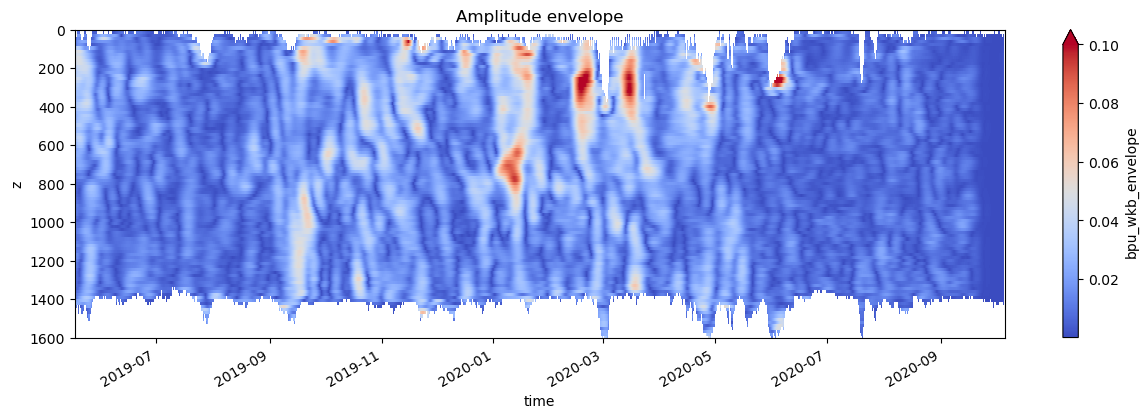

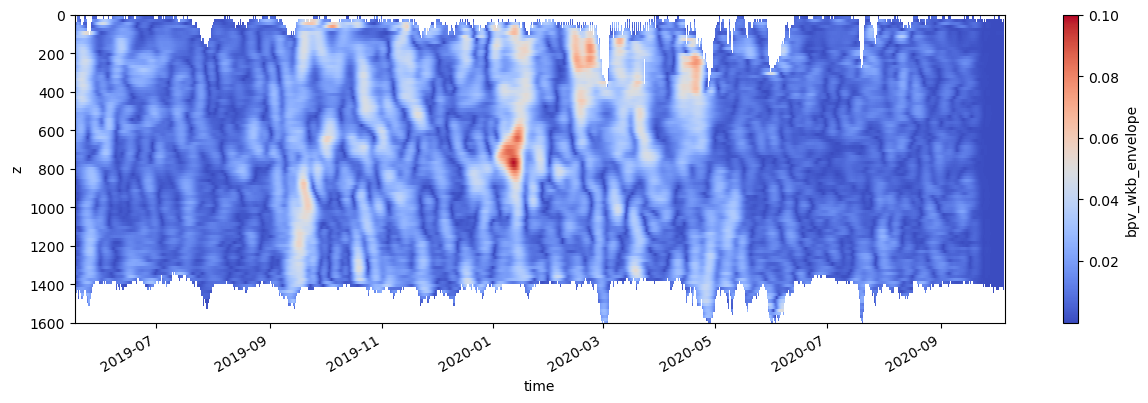

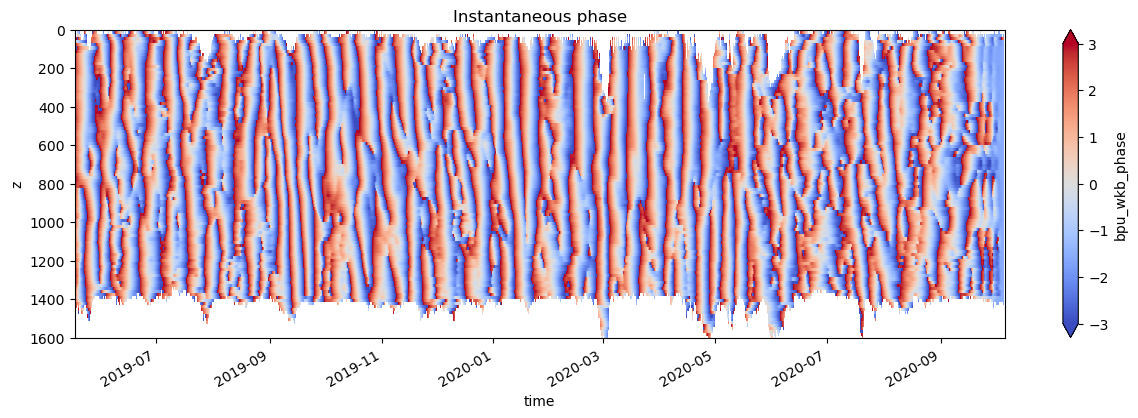

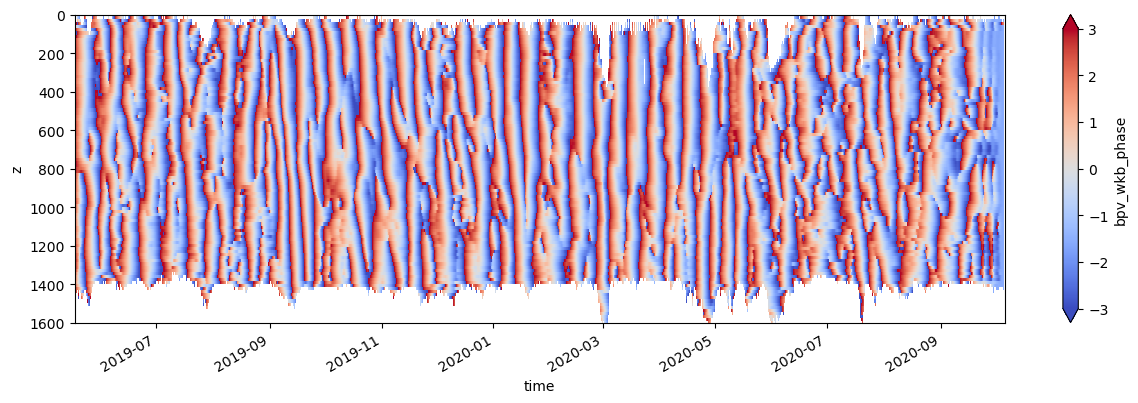

In [126]:
plt.figure(figsize=(15,4))
ds_complex.bpu_wkb_envelope.plot(yincrease=False,ylim=(1600,0),cmap='coolwarm',vmax=0.1)
plt.title('Amplitude envelope')
plt.figure(figsize=(15,4))
ds_complex.bpv_wkb_envelope.plot(yincrease=False,ylim=(1600,0),cmap='coolwarm',vmax=0.1)

plt.figure(figsize=(15,4))
ds_complex.bpu_wkb_phase.plot(yincrease=False,ylim=(1600,0),cmap='coolwarm',vmax=3)
plt.title('Instantaneous phase')
plt.figure(figsize=(15,4))
ds_complex.bpv_wkb_phase.plot(yincrease=False,ylim=(1600,0),cmap='coolwarm',vmax=3)



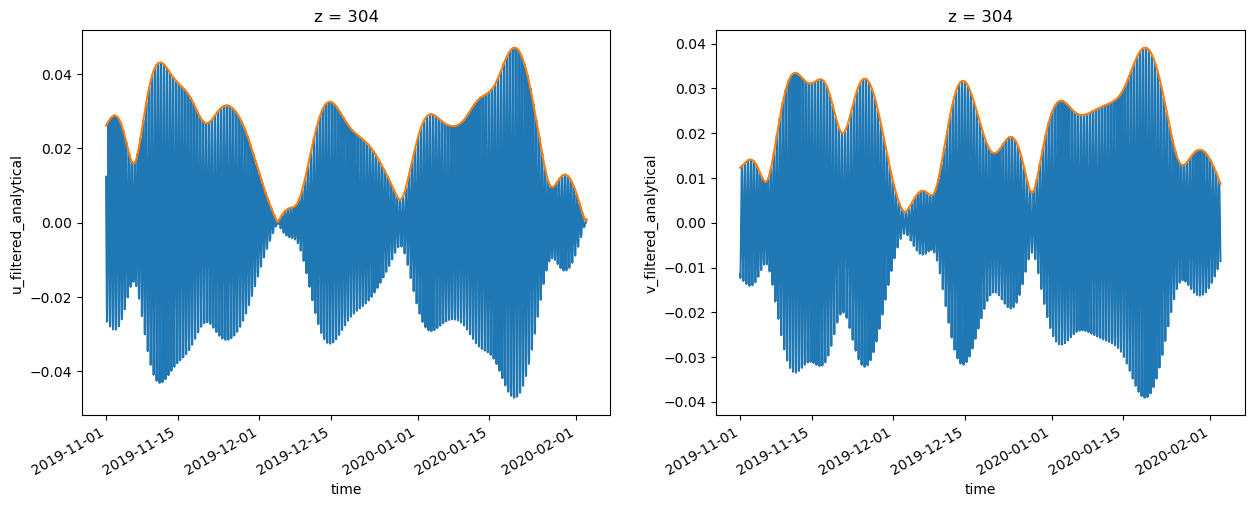

In [127]:
z0,z1 = 300,800
fig,ax = plt.subplots(1,2,figsize=(15,5))
np.real(ds_complex.u_filtered_analytical).sel(z=z0,method='nearest').sel(time=slice('2019-11-01','2020-02-02')).plot(ax=ax[0])
np.real(ds_complex.v_filtered_analytical).sel(z=z0,method='nearest').sel(time=slice('2019-11-01','2020-02-02')).plot(ax=ax[1])
np.abs(ds_complex.u_filtered_analytical).sel(z=z0,method='nearest').sel(time=slice('2019-11-01','2020-02-02')).plot(ax=ax[0])
np.abs(ds_complex.v_filtered_analytical).sel(z=z0,method='nearest').sel(time=slice('2019-11-01','2020-02-02')).plot(ax=ax[1])

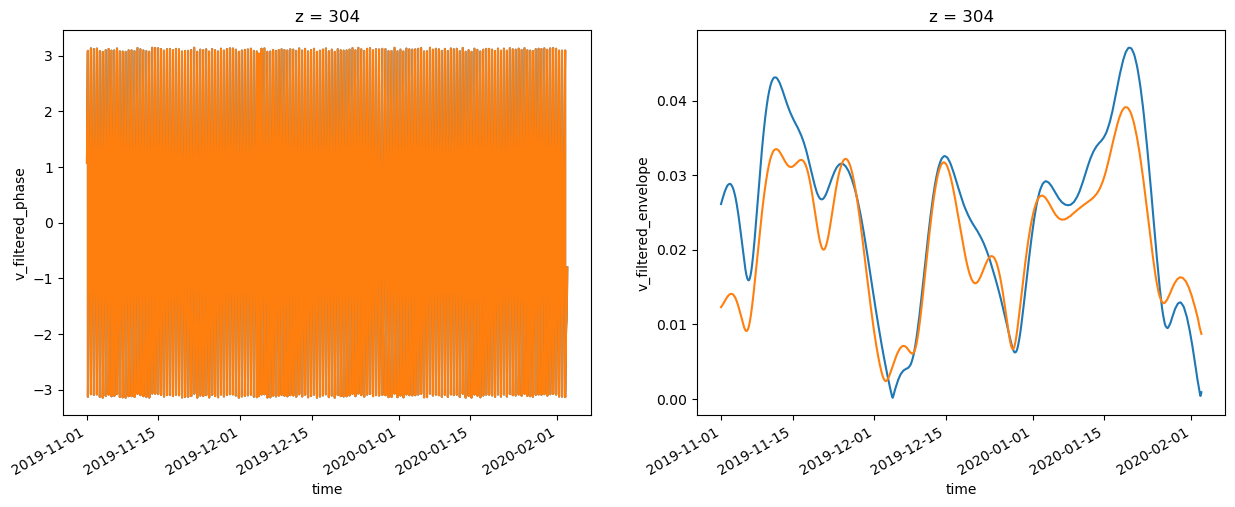

In [128]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ds_complex.u_filtered_phase.sel(z=z0,method='nearest').sel(time=slice('2019-11-01','2020-02-02')).plot(ax=ax[0])
ds_complex.v_filtered_phase.sel(z=z0,method='nearest').sel(time=slice('2019-11-01','2020-02-02')).plot(ax=ax[0])
ds_complex.u_filtered_envelope.sel(z=z0,method='nearest').sel(time=slice('2019-11-01','2020-02-02')).plot(ax=ax[1])
ds_complex.v_filtered_envelope.sel(z=z0,method='nearest').sel(time=slice('2019-11-01','2020-02-02')).plot(ax=ax[1])

In [207]:
omega

1.720854399161123

In [218]:
def wrap_demodulation(ds_hat,V,omega=omega,dt=1/24/6):
    time = np.arange(0,ds_hat['time'].values.size*dt,dt)
    exp = np.exp(-1j*omega*2*np.pi*time)

#    _ds = ut._reset_chunk_encoding(_ds)
#    _ds = _ds.chunk(dict(time=16,i=100,j=100))
#    ds_hat={}
    for v in V:
#        ds_hat[v+'_hat'] = ds_hat[v+'_hat_real']+1j*ds_hat[v+'_hat_imag']
#        ds_hat[v+'_hat'] = ds_hat[v+'_hat'].assign_coords({'lon':ds_hat[v+'_hat'].lon,'lat':ds_hat[v+'_hat'].lat})
        ds_hat[v+'_demodulated'] = ds_hat[v+'_analytical']*exp
        ds_hat[v+'_demodulated_real'] = ds_hat[v+'_demodulated'].real
        ds_hat[v+'_demodulated_imag'] = ds_hat[v+'_demodulated'].imag
        ds_hat[v+'_demodulated_abs'] = np.abs(ds_hat[v+'_demodulated'])
    #ds_hat = xr.merge([ds_hat[v].rename(v) for v in ds_hat.keys()]).drop([v+'_demodulated',v+'_analytical'])
 #   ds_hat = ds_hat.chunk(dict(i=100)) #,j=4320//4
    
    return ds_hat#.drop(['XC','YC'])

In [219]:
ds_complex

<xarray.Dataset>
Dimensions:                   (z: 125, time: 73057)
Coordinates:
  * time                      (time) datetime64[ns] 2019-05-17T16:00:00 ... 2...
  * z                         (z) int64 0 16 32 48 64 ... 1936 1952 1968 1984
Data variables: (12/31)
    u                         (z, time) float64 nan nan nan nan ... nan nan nan
    v                         (z, time) float64 nan nan nan nan ... nan nan nan
    u_filtered                (z, time) float64 nan nan nan nan ... nan nan nan
    v_filtered                (z, time) float64 nan nan nan nan ... nan nan nan
    mld                       (time, z) float64 nan nan nan nan ... nan nan nan
    bpu_wkb                   (z, time) float64 nan nan nan nan ... nan nan nan
    ...                        ...
    bpu_wkb_demodulated_imag  (z, time) float64 nan nan nan nan ... nan nan nan
    bpu_wkb_demodulated_abs   (z, time) float64 nan nan nan nan ... nan nan nan
    bpv_wkb_demodulated       (z, time) complex128 (nan+nanj) ... (nan+nanj)
    bpv_wkb_demodulated_real  (z, time) float64 nan nan nan nan ... nan nan nan
    bpv_wkb_demodulated_imag  (z, time) float64 nan nan nan nan ... nan nan nan
    bpv_wkb_demodulated_abs   (z, time) float64 nan nan nan nan ... nan nan nan
Attributes:
    orientation:      down
    magdec:           -10.915967
    max_e:            0.2
    max_e_deviation:  2
    min_correlation:  64
    mooring:          M1
    sn:               13481
    project:          NISKINe
    Bin1Dist:         24.59
    NCells:           44
    CellSize:         16.0
    proc time:        2022-05-09T19:08:16

In [209]:
_ds = wrap_demodulation(ds_complex,['bpu_wkb','bpv_wkb'])

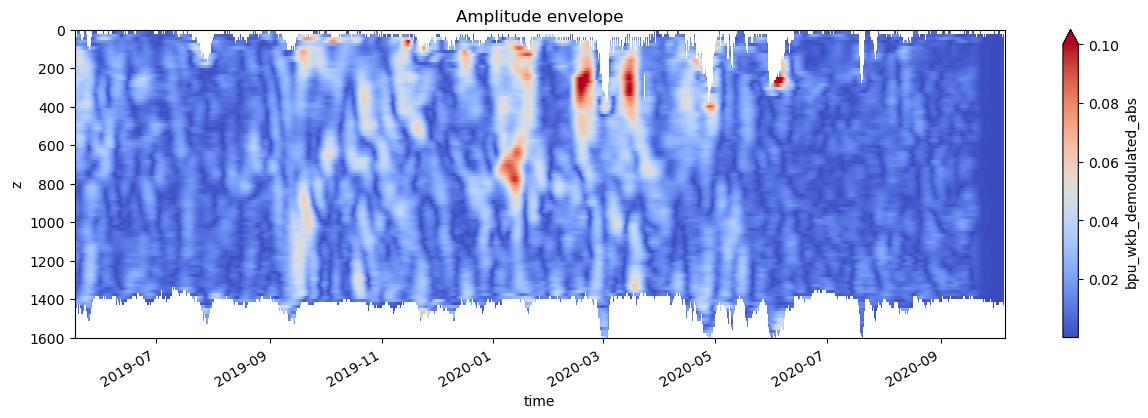

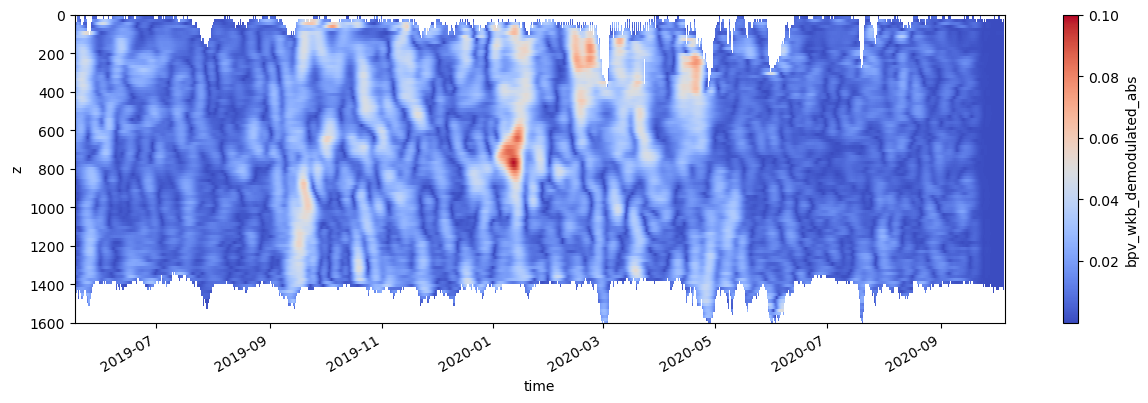

In [210]:
plt.figure(figsize=(15,4))
_ds.bpu_wkb_demodulated_abs.plot(yincrease=False,ylim=(1600,0),cmap='coolwarm',vmax=0.1)
plt.title('Amplitude envelope')
plt.figure(figsize=(15,4))
_ds.bpv_wkb_demodulated_abs.plot(yincrease=False,ylim=(1600,0),cmap='coolwarm',vmax=0.1)


In [211]:
S2 = 2.
M2 = 1.9323

In [212]:
ds_copy = _ds.copy()
ds_copy = ds_copy.fillna(0)

In [213]:
ds_copy['UV_demodulated'] = ds_copy.bpu_wkb_demodulated_real+1j*ds_copy.bpv_wkb_demodulated_real

In [214]:
f,E = sp.wrap_spectra(ds_copy.sel(time=slice('2019-06-01','2020-09-25')),'bpu_wkb_demodulated_real')

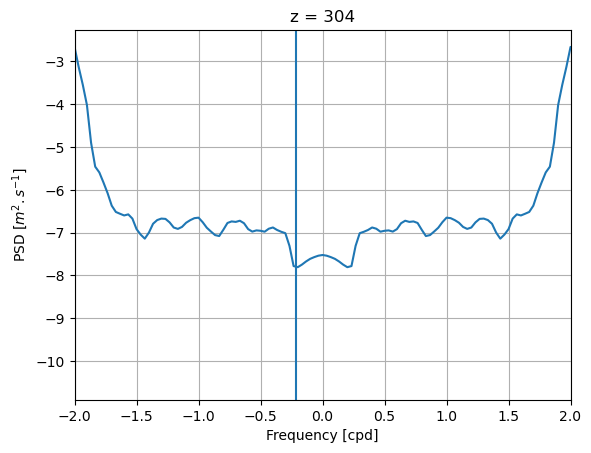

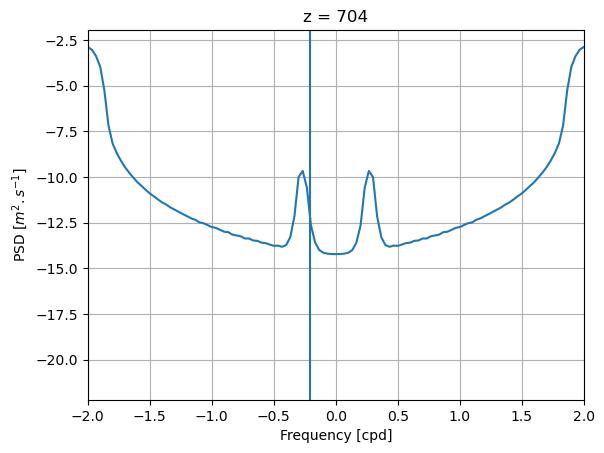

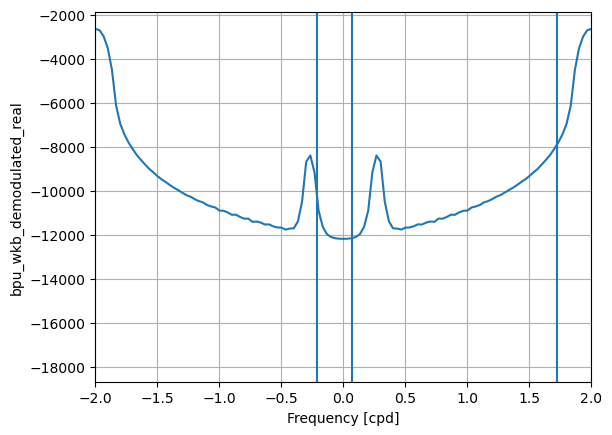

In [215]:
np.log10(E.sel(z=300,method='nearest')).plot(xlim=(-2,2))
plt.axvline(-M2+omega)
plt.grid()

plt.figure()
np.log10(E.sel(z=700,method='nearest')).plot(xlim=(-2,2))
plt.axvline(-M2+omega)
plt.grid()

plt.figure()
np.log10(E.sel(z=slice(400,1250))).integrate('z').plot(xlim=(-2,2))
plt.axvline(-M2+omega)
plt.axvline(S2-M2)
plt.axvline(omega)
plt.grid()

/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


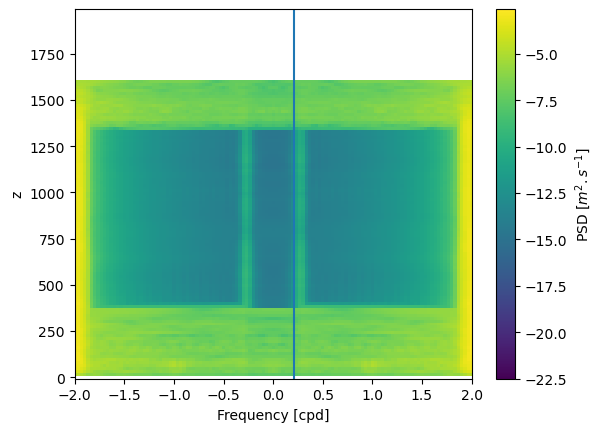

In [216]:
np.log10(E).plot(xlim=(-2,2))
plt.axvline(M2-omega)

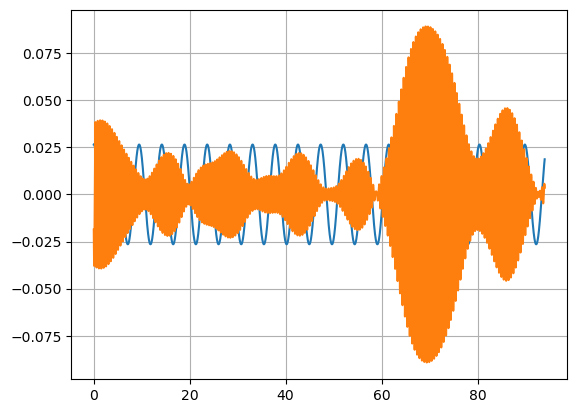

In [217]:
dt = 1/24/6
time = np.arange(0,ds_complex['time'].sel(time=slice('2019-11-01','2020-02-02')).values.size*dt,dt)
exp = np.exp(-1j*(M2-omega)*2*np.pi*time)
plt.plot(time,np.abs(_ds.bpu_wkb_demodulated.sel(time=slice('2019-11-01','2020-02-02'))).sel(z=700,method='nearest').mean().values*exp.real)
plt.plot(time,_ds.bpu_wkb_demodulated.sel(time=slice('2019-11-01','2020-02-02')).real.sel(z=700,method='nearest').values)
plt.grid()

In [178]:
U = ds_complex.bpu_wkb_demodulated.mean('time')
V = ds_complex.bpv_wkb_demodulated.mean('time')

In [196]:
ds_complex

<xarray.Dataset>
Dimensions:                   (z: 125, time: 73057)
Coordinates:
  * time                      (time) datetime64[ns] 2019-05-17T16:00:00 ... 2...
  * z                         (z) int64 0 16 32 48 64 ... 1936 1952 1968 1984
Data variables: (12/31)
    u                         (z, time) float64 nan nan nan nan ... nan nan nan
    v                         (z, time) float64 nan nan nan nan ... nan nan nan
    u_filtered                (z, time) float64 nan nan nan nan ... nan nan nan
    v_filtered                (z, time) float64 nan nan nan nan ... nan nan nan
    mld                       (time, z) float64 nan nan nan nan ... nan nan nan
    bpu_wkb                   (z, time) float64 nan nan nan nan ... nan nan nan
    ...                        ...
    bpu_wkb_demodulated_imag  (z, time) float64 nan nan nan nan ... nan nan nan
    bpu_wkb_demodulated_abs   (z, time) float64 nan nan nan nan ... nan nan nan
    bpv_wkb_demodulated       (z, time) complex128 (nan+nanj) ... (nan+nanj)
    bpv_wkb_demodulated_real  (z, time) float64 nan nan nan nan ... nan nan nan
    bpv_wkb_demodulated_imag  (z, time) float64 nan nan nan nan ... nan nan nan
    bpv_wkb_demodulated_abs   (z, time) float64 nan nan nan nan ... nan nan nan
Attributes:
    orientation:      down
    magdec:           -10.915967
    max_e:            0.2
    max_e_deviation:  2
    min_correlation:  64
    mooring:          M1
    sn:               13481
    project:          NISKINe
    Bin1Dist:         24.59
    NCells:           44
    CellSize:         16.0
    proc time:        2022-05-09T19:08:16

In [191]:
time = np.arange(0,ds_complex['time'].values.size*dt,dt)
u_app = np.mean(U.real).values*np.exp(-1j*omega*2*np.pi*time)
v_app = np.mean(V.real).values*np.exp(-1j*omega*2*np.pi*time)

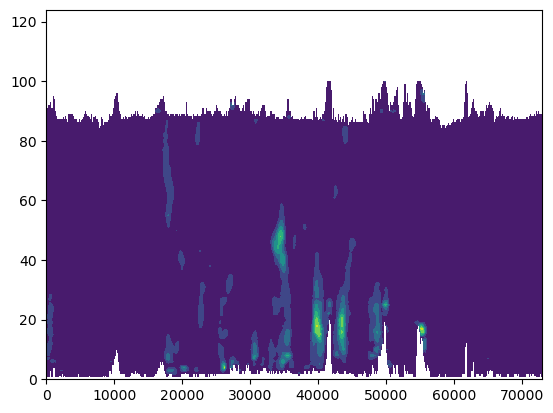

In [193]:
plt.contourf((np.abs(ds_complex.bpu_wkb.values-u_app)**2+np.abs(ds_complex.bpv_wkb.values-v_app)**2))

Object `np.integrate` not found.


In [ ]:
def r_sq(u,v):
    return 1-(np.abs(ds_complex.bpu_wkb.values-u_app)**2+np.abs(ds_complex.bpv_wkb.values-v_app)**2).integrate(axis=-1)/()

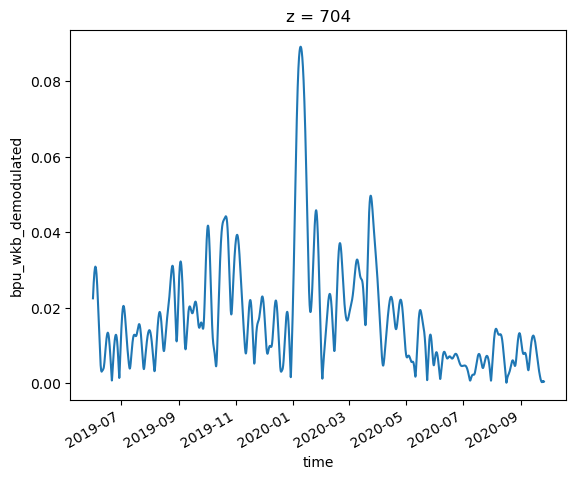

In [169]:
np.abs(_ds.bpu_wkb_demodulated).sel(z=700,method='nearest').sel(time=slice('2019-06-01','2020-09-25')).plot()

In [ ]:
c